#Sentiment LLM Training and Evaluation
This notebook implements an LLM training and evaluation workflow using open-source python libraries. It is assumed that the user knows the basics of python, using libraries, and surface level ML knowledge which can be helpful in understanding evaluation metrics.

This project uses hugging-face libraries, which make it simple to implement open source models from the hub. It should be noted however that this project is not implemented in a closed environment. That is to say that users should be aware of any data used in the project file and any calls made to external libraries or api's.



## Model Evaluation Workflow
Below is a general outline for the process of training, evaluating, and selecting a model for deployment.

### Selecting benchmarks-
When selecting a benchmark, an analyst or programmer should be aware of the task which they are trying to measure or evaluate. Benchmarks used for sentiment classification or general QA tasks may not be useful for measuring programming tasks.

This article gives a great overview of ML benchmarks, what they measure, and where they fail:
https://deepgram.com/learn/llm-benchmarks-guide-to-evaluating-language-models

For general ML model evaluation and statistics this article is a good start:
https://neptune.ai/blog/ml-model-evaluation-and-selection

### Preparing Datasets
Data preperation is an essential part in Machine Learning. In an enterprise context, this will eventually mean selecting data which contextually represents a business problem. For example, if an organization wanted to train a fraud detection model, it might collect data on previous labeled fraud cases and compile it with other verified transactions.

In any case, the datasets must be large enough to obtain a high quality and objective evaluation. This includes training, validation, and test sets.

Other preperation may involve data preprocessing, such as tokenization, which is used for data inputs intended for models designed for language based tasks.

For more on preparing data, see:
https://blog.jetbrains.com/datalore/2022/11/08/how-to-prepare-your-dataset-for-machine-learning-and-analysis/

### Training and Fine Tuning models
This step involves the actual training of an ML model. For example, in the case of NLP, pre-training on a large text corpus and then fine-tuning on a benchmark data set which is intended for a specific task.

For more on training and fine tuning, you can check out the following link: https://www.analyticsvidhya.com/blog/2023/08/finetuning-large-language-models-llms/

For more on training and fine tuning using hugging-face trainer see:
https://huggingface.co/transformers/v3.3.1/training.html


### Evaluating Models
Model evaluation is performed using a set of predefined metrics specific to a task or characteristic desired of the model. Metrics like accuracy (the percentage of correct predictions over all predictions) can be used to measure model performance in a general sense. However, there are also benchmarks which exist which have been created to measure a broader set of characteristics. HumanEvals is a benchmark which measures a models ability to generate code which uses it's own metric Pass@k.

For more a guide on Machine Learning Evaluation and performance metrics, see:
https://neptune.ai/blog/performance-metrics-in-machine-learning-complete-guide

### Performing a Comparative Analysis
Once a common benchmark has been defined, models selected and trained, they can be evaluated and compared against each other. This can help a user determine which model is most suitable to deploy for a single or set of tasks. The specific implementation will depend on the over all tech stack preferred by the user or team.

For an example of comparison you can check out the HumanEvals leaderboard. It compares a range of large language models' performence on the HumanEvals evaluation benchmark. You can see their pass@k scores compared along with model information in a table:

https://paperswithcode.com/sota/code-generation-on-humaneval

You can also check out hugging-face's Open-LLM leaderboard:
https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard



# Imports/Dependencies
First section imports all required libraries/dependencies for the workflow.

In [ ]:
! pip install -U accelerate
! pip install -U transformers
! pip install -U evaluate

In [ ]:
! pip install datasets transformers huggingface_hub
! pip install tiktoken

In [ ]:
import transformers

## Importing Transformers
This projects workflow will be using the Transformers library:

https://huggingface.co/docs/transformers/index




## Importing your model
In the below sections code, the training dataset and Language Model are imported and intitialized.

In our case, we are using distilbert-base-uncased, which is a "distilled version of the BERT base model.

The data is pretrained on the same data as BERT. " BookCorpus"

Book Corpus
https://yknzhu.wixsite.com/mbweb

https://arxiv.org/abs/1910.01108
https://huggingface.co/distilbert-base-uncased

In [110]:
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import accelerate
import torch
torch.cuda.is_available()
import datasets
from datasets import load_dataset
import numpy as np
import evaluate
from evaluate import load
from evaluate import visualization
from datasets import load_metric, list_metrics
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding

## Assign model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")
transformers.__version__, accelerate.__version__
d_set = load_dataset("imdb")

# Train Data Set
https://huggingface.co/transformers/v4.8.2/training.html

Fine tuning a pretrained model.



In [ ]:
small_train_dataset = d_set["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = d_set["test"].shuffle(seed=42).select([i for i in list(range(300))])

## Compute Metrics Function
compute_metrics initializes the metrics which we want to evaluate the LLM's outputs with and then prints out their values.

Metrics are loaded using the 'evaluate.load' method from the evaluate library. Other evaluation methods may have their own implementation, so it is good practice to review each libraries documentation before implementing.

Below, I have defined a few metrics. Accuracy and F1, along with the super glue benchmark:

The metrics are computed using the 'compute' method which is called with the variables previously initialized.

Labels are known values which are used to measure our model. Generally, when training an ML model, we want to have a labeled data set. In unsupervised learning, the model will gradually learn the relationships between the features we have defined in our data set and the labels known.

You can learn more about labels and machine learning here:
https://developers.google.com/machine-learning/crash-course/framing/ml-terminology



In [ ]:
#define the evaluation metrics which we want to output
## below in this case, we output some generic evaluation metrics
## f1 is commented out because there is a runtime error using hugging faces f1 metric listed on their repo
def compute_metrics(eval_pred):
  load_accuracy = evaluate.load("accuracy")
  load_f1 = evaluate.load("f1")
  load_super_glue_metric = load('super_glue', 'copa')



  logits, labels = eval_pred
  predictions = np.argmax(logits, axis =-1)
  accuracy = load_accuracy.compute(predictions=predictions, references = labels)["accuracy"]
  f1 = load_f1.compute(predictions=predictions, references = labels)["f1"]
  super_glue = load_super_glue_metric.compute(predictions=predictions, references = labels)
  return {"accuracy":accuracy, 'f1':f1, 'super_glue':super_glue}

# Tokenization/Preprocessing
Tokenization is a sort of preprocessing done on the inputs for the model. It breaks down sentences into sub-strings which can then be processed by the model. Each word or substring then receives an id or 'token' which makes the data more readable.

We are using the transformers tokenizer from hugging face, but there are other open source libraries which can be used.


https://huggingface.co/docs/transformers/main_classes/tokenizer



In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
def preprocess_function(examples):
  return tokenizer(examples["text"], truncation = True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

## Notebook Login Token
User access tokens allow you to access hugging face repositories from your project. You can read more on user access tokens here: https://huggingface.co/docs/hub/security-tokens.


You can read on how to create a repository here: https://huggingface.co/docs/hub/repositories-getting-started


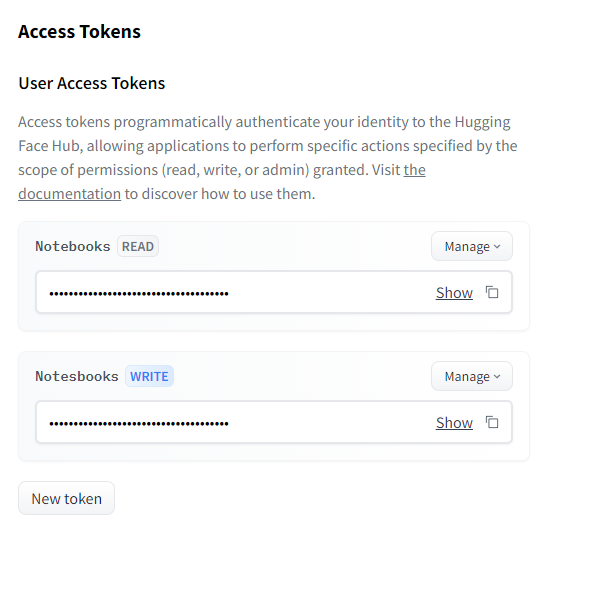

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# Training/Evaluation
Once a repository has been defined as our output directory, the trainer can be initialized. In this project file, we are using the trainer libary from hugging face.

You can read more about how to train or fine-tune models using the trainer here:
https://huggingface.co/docs/transformers/training

For now, default parameters are used in the training arguments.




In [ ]:
#define the repo from which to output to. This should be the notebook which we imported using the token stored in the notebook file.
## See
repo_name = "distilbert-base-uncased"

#define our directory
training_args = TrainingArguments(
   output_dir="distilbert-base-uncased",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

#instantiates our trainer
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [106]:
#This call will perform our fine tuning.
trainer.train()

Step,Training Loss


KeyboardInterrupt: ignored

# Evaluation
This project uses the hugging face evaluate libarary. This library is a useful open source libary which enables the evaluation of Machine Learning models and datasets.

You can read more about the library here on their website for tutorials and documentation.

In our case. We are using the Evaluate library with the Transformers ML framework.

https://huggingface.co/docs/evaluate/index

You can find more about choosing the right evaluation metrics as well on this page:
https://huggingface.co/docs/evaluate/choosing_a_metric




## Evaluation Cards
Evaluation cards are like modules which you can import into project file to use with the evaluations library. You can find commonly used evaluation metrics like SuperGlue here. There's also other metric cards like Code Eval, which use the HumanEvals metric that measure a models performance on code generation related tasks.

In this project, only generaic evaluation metrics were used. However, other evaluation modules can be imported into the project and run the same way the generic metrics are run below.

Another page which desciribes how to load other evaluation modules into evaluate:
https://huggingface.co/docs/evaluate/creating_and_sharing

List of hugging-face evaluation cards:
https://huggingface.co/evaluate-metric

Specific Code evaluation card:
https://huggingface.co/spaces/evaluate-metric/code_eval








In [ ]:
#Compute Evaluation Metrics
trainer.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.8766666666666667}" of type <class 'dict'> for key "eval/super_glue" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Step,Training Loss,Validation Loss,Accuracy,F1,Super Glue
5,No log,0.751419,0.876667,0.881789,{'accuracy': 0.8766666666666667}


{'eval_loss': 0.7514190077781677,
 'eval_accuracy': 0.8766666666666667,
 'eval_f1': 0.8817891373801918,
 'eval_super_glue': {'accuracy': 0.8766666666666667}}

In [ ]:
#upload model to hugging face hub
trainer.push_to_hub()

events.out.tfevents.1702056176.b781954b981d.341.3:   0%|          | 0.00/346 [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1702056225.b781954b981d.341.4:   0%|          | 0.00/389 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

'https://huggingface.co/DangerRat/distilbert-base-uncased/tree/main/'

# Comparing Models
Once models have been trained, it is possible to evaluate them against the same benchmarks.

The workflow would be similar to that of above. However, in this case the evaluation would be performed by using a prebuilt supported evaluation task in the evaluator libarary. Here's the documentation for using the evaluator libarary where you can learn how to compare models on benchmarks:
https://huggingface.co/docs/evaluate/base_evaluator

Custom evaluation pipelines can be built, which can call other evaluation libraries not currently supported with the evaluator. To read more about building custom evaluations, see: https://huggingface.co/docs/evaluate/custom_evaluator


**Note ** Below code is not functioning in this version. Working on fixing.


In [105]:
import pandas as pd
from evaluate import evaluator
from transformers import pipeline

models = [
    "bigscience/bloom",
    "Weyaxi/OpenHermes-2.5-neural-chat-7b-v3-1-7B",
    "elastic/distilbert-base-uncased-finetuned-conll03-english",
    "migtissera/Synthia-70B-v1.2b",
    "gunghio/distilbert-base-multilingual-cased-finetuned-conll2003-ner",
    "philschmid/distilroberta-base-ner-conll2003",
    "Jorgeutd/albert-base-v2-finetuned-ner",
]

data = load_dataset("imdb")
task_evaluator = evaluator("token-classification")

results = []
for model in models:
    results.append(
        task_evaluator.compute(
            model_or_pipeline=model, data=data, metric="seqeval"
            )
        )

df = pd.DataFrame(results, index=models)
df[["overall_f1", "overall_accuracy", "total_time_in_seconds", "samples_per_second", "latency_in_seconds"]]

ValueError: ignored

## Visualization

While visualization is not currently implemented in this version, it can be useful for an analyst to be able to see graphical representations of model outputs evaluation results, or even the hyperparameters they are tuning.

Radar graphs will be useful for visualizing the comparison of multiple metrics and benchmarks on different models. Hugging face has their own function which I was unable to implement. It takes in metrics and models as input to display in a rader graph:
https://huggingface.co/docs/evaluate/package_reference/visualization_methods


For more on visualization you can see:
https://towardsdatascience.com/visualize-machine-learning-metrics-like-a-pro-b0d5d7815065

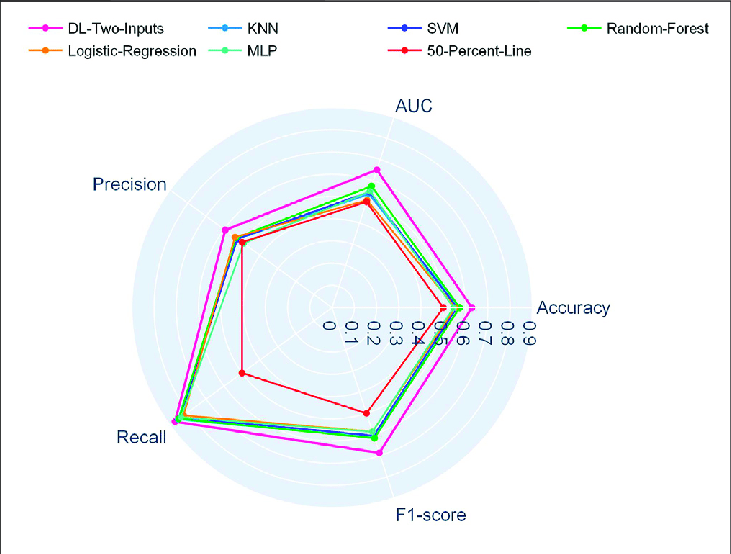